# IMPORT LIBRARIES

In [41]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
! pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
!pip install pandas-ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta

In [46]:
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [47]:
from datetime import datetime

In [48]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [49]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense, Flatten
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from keras.utils.vis_utils import plot_model

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

%matplotlib inline

import seaborn as sns
sns.set()

# **TA data for LSTM 1**

In [72]:
data = yf.download(tickers ='EURUSD=X', end= '2022-11-11')
data.to_csv('EURUSDPrice.csv')
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,0
2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,0
2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,0
2022-11-09,1.008085,1.008878,1.001252,1.008085,1.008085,0
2022-11-10,1.001954,1.018299,0.993779,1.001954,1.001954,0


In [73]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['SMA']= ta.sma(data.Close, length=10)
data['EMA']= ta.ema(data.Close, length= 10)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)
macd = data.ta.macd(fast =12, slow =26, signal =9)
BB = data.ta.bbands(length=12, std =2)
ADX = data.ta.adx(length = 20)
ROC = data.ta.roc(length = 12)

dataTA = pd.concat([data, macd, BB, ADX, ROC], axis = 1)

In [74]:
dataTA['returns'] = (dataTA['Adj Close']/dataTA['Adj Close'].shift(1)) -1
dataTA['returnsclass'] = [1 if dataTA.returns[i]>0 else 0 for i in range(len(dataTA))]
dataTA.drop(['Volume'], axis=1, inplace=True)

In [75]:
dataTA.dropna(inplace=True)

In [76]:
data_set = dataTA.iloc[:, ]#.values
pd.set_option('display.max_columns', None)

data_set

,Open,High,Low,Close,Adj Close,RSI,SMA,EMA,EMAF,EMAM,EMAS,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_12_2.0,BBM_12_2.0,BBU_12_2.0,BBB_12_2.0,BBP_12_2.0,ADX_20,DMP_20,DMN_20,ROC_12,returns,returnsclass
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2004-06-25,1.217093,1.220301,1.211299,1.220301,1.220301,54.911255,1.211252,1.213470,1.212295,1.219270,1.228477,0.001650,0.000118,0.001532,1.198109,1.210410,1.222711,2.032554,0.902022,10.529251,19.865586,19.370648,1.328905,0.002380,1
2004-06-28,1.217493,1.222703,1.212797,1.218695,1.218695,53.966191,1.212501,1.214420,1.212905,1.219258,1.228347,0.001964,0.000346,0.001618,1.197928,1.211060,1.224191,2.168541,0.790725,10.197999,20.052943,18.542993,0.643457,-0.001316,0
2004-06-29,1.218695,1.219096,1.207496,1.209804,1.209804,48.968246,1.211821,1.213581,1.212610,1.219071,1.228101,0.001478,-0.000112,0.001590,1.199894,1.211751,1.223609,1.957117,0.417904,9.797026,19.049638,19.901794,0.690796,-0.007295,0
2004-06-30,1.209497,1.220301,1.206797,1.218398,1.218398,53.434557,1.213591,1.214457,1.213161,1.219058,1.227973,0.001766,0.000141,0.001625,1.200897,1.212768,1.224639,1.957702,0.737134,9.345300,18.464605,18.752050,1.011273,0.007103,1
2004-07-01,1.218294,1.220807,1.213902,1.216205,1.216205,52.185715,1.214872,1.214775,1.213451,1.219001,1.227817,0.001797,0.000138,0.001660,1.200904,1.212734,1.224565,1.950986,0.646672,8.885485,18.128930,18.186492,-0.032835,-0.001800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,43.011123,0.990533,0.986115,0.985942,1.007830,1.025200,-0.000073,-0.000374,0.000301,0.969172,0.988323,1.007473,3.875445,0.151205,10.588025,18.945042,19.588859,-1.158250,-0.006600,0
2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,53.118878,0.991220,0.987345,0.986603,1.007534,1.024771,0.000468,0.000133,0.000335,0.971761,0.989675,1.007590,3.620319,0.589474,10.311693,19.627748,17.736596,1.662092,0.018378,1
2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,57.196524,0.992542,0.989985,0.988056,1.007421,1.024468,0.001603,0.001014,0.000588,0.974118,0.991673,1.009228,3.540559,0.790236,10.453165,21.704507,16.662629,2.451556,0.009047,1


In [77]:
data_set_count = data_set[['Close','returnsclass']].copy()
data_set_count = data_set_count.groupby('returnsclass').count()
data_set_count =data_set_count.rename(columns={'Close':'Count'})
data_set_count

,Count
returnsclass,
0,2394
1,2372


In [78]:
#drop range of rows so first date of data_set can match with twitter sentiment data
data_set=data_set.drop(data_set.index[0:2445])

In [79]:
data_set

,Open,High,Low,Close,Adj Close,RSI,SMA,EMA,EMAF,EMAM,EMAS,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_12_2.0,BBM_12_2.0,BBU_12_2.0,BBB_12_2.0,BBP_12_2.0,ADX_20,DMP_20,DMN_20,ROC_12,returns,returnsclass
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-16,1.373815,1.379900,1.373815,1.373928,1.373928,61.180787,1.368764,1.369946,1.364524,1.347592,1.339880,0.005894,0.002006,0.003889,1.350766,1.367213,1.383660,2.405920,0.704164,15.357994,22.396920,14.854837,1.220049,-0.000838,0
2013-12-17,1.376178,1.378210,1.372701,1.376292,1.376292,62.811095,1.370973,1.371100,1.365645,1.348160,1.340363,0.006076,0.001750,0.004326,1.351940,1.368537,1.385135,2.425581,0.733614,15.493713,21.662505,15.031101,1.168472,0.001720,1
2013-12-18,1.377107,1.378099,1.373479,1.377126,1.377126,63.392301,1.372779,1.372196,1.366738,1.348734,1.340849,0.006216,0.001512,0.004704,1.354059,1.370088,1.386118,2.339867,0.719524,15.622646,21.053065,14.608225,1.370242,0.000606,1
2013-12-19,1.368307,1.369394,1.365113,1.368495,1.368495,54.028961,1.373764,1.371523,1.366905,1.349125,1.341216,0.005567,0.000690,0.004877,1.358317,1.371279,1.384242,1.890574,0.392590,14.973438,19.547899,18.542880,1.055106,-0.006268,0
2013-12-20,1.365598,1.370870,1.362583,1.365579,1.365579,51.287513,1.373623,1.370442,1.366779,1.349451,1.341538,0.004762,-0.000092,0.004854,1.360510,1.371822,1.383133,1.649117,0.224048,14.297832,18.583230,19.134403,0.479314,-0.002130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,43.011123,0.990533,0.986115,0.985942,1.007830,1.025200,-0.000073,-0.000374,0.000301,0.969172,0.988323,1.007473,3.875445,0.151205,10.588025,18.945042,19.588859,-1.158250,-0.006600,0
2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,53.118878,0.991220,0.987345,0.986603,1.007534,1.024771,0.000468,0.000133,0.000335,0.971761,0.989675,1.007590,3.620319,0.589474,10.311693,19.627748,17.736596,1.662092,0.018378,1
2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,57.196524,0.992542,0.989985,0.988056,1.007421,1.024468,0.001603,0.001014,0.000588,0.974118,0.991673,1.009228,3.540559,0.790236,10.453165,21.704507,16.662629,2.451556,0.009047,1


In [80]:
# data_set.drop(['Open', 'High', 'Low', 'Close', 'Adj Close','returns'], axis=1, inplace=True)
data_set.drop(['returns'], axis=1, inplace=True)
data_set

,Open,High,Low,Close,Adj Close,RSI,SMA,EMA,EMAF,EMAM,EMAS,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_12_2.0,BBM_12_2.0,BBU_12_2.0,BBB_12_2.0,BBP_12_2.0,ADX_20,DMP_20,DMN_20,ROC_12,returnsclass
Date,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-16,1.373815,1.379900,1.373815,1.373928,1.373928,61.180787,1.368764,1.369946,1.364524,1.347592,1.339880,0.005894,0.002006,0.003889,1.350766,1.367213,1.383660,2.405920,0.704164,15.357994,22.396920,14.854837,1.220049,0
2013-12-17,1.376178,1.378210,1.372701,1.376292,1.376292,62.811095,1.370973,1.371100,1.365645,1.348160,1.340363,0.006076,0.001750,0.004326,1.351940,1.368537,1.385135,2.425581,0.733614,15.493713,21.662505,15.031101,1.168472,1
2013-12-18,1.377107,1.378099,1.373479,1.377126,1.377126,63.392301,1.372779,1.372196,1.366738,1.348734,1.340849,0.006216,0.001512,0.004704,1.354059,1.370088,1.386118,2.339867,0.719524,15.622646,21.053065,14.608225,1.370242,1
2013-12-19,1.368307,1.369394,1.365113,1.368495,1.368495,54.028961,1.373764,1.371523,1.366905,1.349125,1.341216,0.005567,0.000690,0.004877,1.358317,1.371279,1.384242,1.890574,0.392590,14.973438,19.547899,18.542880,1.055106,0
2013-12-20,1.365598,1.370870,1.362583,1.365579,1.365579,51.287513,1.373623,1.370442,1.366779,1.349451,1.341538,0.004762,-0.000092,0.004854,1.360510,1.371822,1.383133,1.649117,0.224048,14.297832,18.583230,19.134403,0.479314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,43.011123,0.990533,0.986115,0.985942,1.007830,1.025200,-0.000073,-0.000374,0.000301,0.969172,0.988323,1.007473,3.875445,0.151205,10.588025,18.945042,19.588859,-1.158250,0
2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,53.118878,0.991220,0.987345,0.986603,1.007534,1.024771,0.000468,0.000133,0.000335,0.971761,0.989675,1.007590,3.620319,0.589474,10.311693,19.627748,17.736596,1.662092,1
2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,57.196524,0.992542,0.989985,0.988056,1.007421,1.024468,0.001603,0.001014,0.000588,0.974118,0.991673,1.009228,3.540559,0.790236,10.453165,21.704507,16.662629,2.451556,1


# **SA with Vader data for LSTM2**

In [13]:
from google.colab import files

In [14]:
files.upload()

Saving EUcentralbank_finBert.csv to EUcentralbank_finBert.csv
Saving EUinflation_finBert.csv to EUinflation_finBert.csv
Saving EUinterestrate_finBert.csv to EUinterestrate_finBert.csv
Saving EUrecession_finBert.csv to EUrecession_finBert.csv
Saving EUtax_finBert.csv to EUtax_finBert.csv
Saving macroeconomic_finBert.csv to macroeconomic_finBert.csv
Saving USFed_finBert.csv to USFed_finBert.csv
Saving USinflation_finBert.csv to USinflation_finBert.csv
Saving USinterestrate_finBert.csv to USinterestrate_finBert.csv
Saving USrecession2_finBert.csv to USrecession2_finBert.csv
Saving UStax_finBert.csv to UStax_finBert.csv


## Download Tweets

In [51]:
tweet1 = pd.read_csv('EUcentralbank_finBert.csv')
tweet2 = pd.read_csv('EUinflation_finBert.csv')
tweet3 = pd.read_csv('EUinterestrate_finBert.csv')
tweet4 = pd.read_csv('EUrecession_finBert.csv')
tweet5 = pd.read_csv('EUtax_finBert.csv')
tweet6 = pd.read_csv('macroeconomic_finBert.csv')
tweet7 = pd.read_csv('USFed_finBert.csv')
tweet8 = pd.read_csv('USinflation_finBert.csv')
tweet9 = pd.read_csv('USinterestrate_finBert.csv')
tweet10 = pd.read_csv('USrecession2_finBert.csv')
tweet11 = pd.read_csv('UStax_finBert.csv')

In [52]:
frames = [tweet1, tweet2, tweet3, tweet4, tweet5, tweet6, tweet7, tweet8, tweet9, tweet10, tweet11]
tweet=pd.concat(frames)

In [53]:
tweet['Date'] = pd.to_datetime(tweet['Date'], errors='coerce')
tweet['Date'] = tweet['Date'].dt.strftime('%Y-%m-%d')

In [54]:
tweet= tweet.sort_values(by=['Date'])

In [55]:
tweet.head()

,Date,User,twee,sentiment
0,2013-12-16,Habus,eu central bank warns against the bitcoin comp...,neutral
10,2013-12-16,Educ_Reform,is it a surprise that finance has not to date ...,neutral
9,2013-12-16,TotesFacts,the cost of college textbooks in the us has ri...,neutral
8,2013-12-16,mrymler,inb4 ala relax lah maryam the future will work...,neutral
7,2013-12-16,KeithMcCullough,newsflash deflating the inflation in 2014 prov...,neutral


## Vader on Tweets

In [56]:
tokenizerFin = AutoTokenizer.from_pretrained("ProsusAI/finbert")

modelFin = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",num_labels=3)
nlp = pipeline("sentiment-analysis",model=modelFin,tokenizer=tokenizerFin)

In [57]:
analyzer = SentimentIntensityAnalyzer()

In [58]:
def analyze_sentiment_pos(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['pos']

def analyze_sentiment_Neg(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['neg']

def analyze_sentiment_Neu(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['neu']

def analyze_sentiment_Comp(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['compound']

def analyze_sentiment_BERT_int(tweet):
    sentiment_dict = nlp(tweet)
    return sentiment_dict[0]['score']

def analyze_sentiment_BERT(tweet):
    sentiment_dict = nlp(tweet)
    if sentiment_dict[0]['label']=='positive':
      return 1
    elif sentiment_dict[0]['label']=='neutral':
      return 0
    else: return -1

In [59]:
tweet["twee"]  = tweet["twee"].astype(str) 
tweet["Vader_Comp"] = tweet['twee'].apply(analyze_sentiment_Comp)
tweet["Vader_Pos"] = tweet['twee'].apply(analyze_sentiment_pos)
tweet["Vader_Neg"] = tweet['twee'].apply(analyze_sentiment_Neg)
tweet["Vader_Neu"] = tweet['twee'].apply(analyze_sentiment_Neu)

In [60]:
# Drop duplicated tweets
tweet.drop_duplicates(subset='twee',inplace=True)

In [61]:
tweet.shape

(356396, 8)

In [62]:
# Get the day of week column
tweet['weekday']= pd.to_datetime(tweet['Date']).dt.day_name(locale='en_US.utf8')

In [63]:
import datetime
DD = datetime.timedelta(days=1)
#filter for saturdays and Sunday date -1, -2 to become friday
#Saturdays
saturday = tweet['weekday'] == "Saturday"
tweet.loc[saturday,"Date"] = pd.to_datetime(tweet.loc[saturday,"Date"]).dt.date - DD

In [64]:
#Sundays
DD = datetime.timedelta(days=2)

sunday = tweet['weekday'] == "Sunday"
tweet.loc[sunday,"Date"] = pd.to_datetime(tweet.loc[sunday,"Date"]).dt.date - DD

In [65]:
tweet['Date']=pd.to_datetime(tweet['Date'])

In [66]:
tweet.set_index('Date')

,User,twee,sentiment,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,weekday
Date,,,,,,,,
2013-12-16,Habus,eu central bank warns against the bitcoin comp...,neutral,-0.6369,0.000,0.321,0.679,Monday
2013-12-16,Educ_Reform,is it a surprise that finance has not to date ...,neutral,0.2732,0.075,0.000,0.925,Monday
2013-12-16,TotesFacts,the cost of college textbooks in the us has ri...,neutral,0.0000,0.000,0.000,1.000,Monday
2013-12-16,mrymler,inb4 ala relax lah maryam the future will work...,neutral,0.1779,0.120,0.091,0.788,Monday
2013-12-16,KeithMcCullough,newsflash deflating the inflation in 2014 prov...,neutral,0.0000,0.000,0.000,1.000,Monday
...,...,...,...,...,...,...,...,...
2022-11-10,LTSummer22,why cant my woke company give me a raise for i...,neutral,-0.4357,0.000,0.152,0.848,Thursday
2022-11-10,ajbell,big day for us inflation figures whsmith rest...,positive,0.5106,0.121,0.000,0.879,Thursday
2022-11-10,wheeliedealer,stocks looking bit soggy but nothing dramatic ...,negative,-0.4497,0.083,0.111,0.806,Thursday


In [67]:
tweets=tweet.groupby('Date').mean()

<ipython-input-67-6cbc97647edc>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets=tweet.groupby('Date').mean()


In [68]:
tweets

,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu
Date,,,,
2013-12-16,-0.024960,0.083582,0.093522,0.822881
2013-12-17,-0.047185,0.067832,0.087861,0.844327
2013-12-18,0.016943,0.083365,0.078359,0.838269
2013-12-19,0.050499,0.080877,0.070027,0.849055
2013-12-20,-0.079056,0.081355,0.108529,0.810132
...,...,...,...,...
2022-11-04,-0.110068,0.089729,0.117578,0.792692
2022-11-07,-0.111497,0.089589,0.115749,0.794655
2022-11-08,-0.118162,0.087318,0.117181,0.795512


In [69]:
tweets.index = pd.to_datetime(tweets.index) #convert index to datetime format before joining 2 dataframe

## Consolidate Vader and Price

In [81]:
price= pd.read_csv("EURUSDPrice.csv")

In [82]:
price['returns'] = (price['Adj Close']/price['Adj Close'].shift(1)) -1
price['returnsclass'] = [1 if price.returns[i]>0 else 0 for i in range(len(price))]

In [83]:
price.drop(['Volume', 'returns'], axis=1, inplace= True)

In [84]:
price['Date'] = pd.to_datetime(price['Date']) #convert index to datetime format before joining 2 dataframe

In [85]:
price

,Date,Open,High,Low,Close,Adj Close,returnsclass
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,1
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,1
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,1
...,...,...,...,...,...,...,...
4910,2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,0
4911,2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,1
4912,2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,1
4913,2022-11-09,1.008085,1.008878,1.001252,1.008085,1.008085,1


In [86]:
price.set_index(['Date'])

,Open,High,Low,Close,Adj Close,returnsclass
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,1
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,1
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,1
...,...,...,...,...,...,...
2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,0
2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,1
2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,1


In [87]:
df=price.join(tweets, on='Date')

In [88]:
s = df.pop('returnsclass')
new_df = pd.concat([df, s], 1) #move returnclass column to the last 

<ipython-input-88-b8ed0f0eba3c>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  new_df = pd.concat([df, s], 1) #move returnclass column to the last


In [89]:
new_df

,Date,Open,High,Low,Close,Adj Close,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,returnsclass
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,NaN,NaN,NaN,NaN,0
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,NaN,NaN,NaN,NaN,1
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,NaN,NaN,NaN,NaN,1
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,NaN,NaN,NaN,NaN,0
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
4910,2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,-0.110068,0.089729,0.117578,0.792692,0
4911,2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,-0.111497,0.089589,0.115749,0.794655,1
4912,2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,-0.118162,0.087318,0.117181,0.795512,1
4913,2022-11-09,1.008085,1.008878,1.001252,1.008085,1.008085,-0.177959,0.084545,0.129206,0.786283,1


In [90]:
new_df= new_df.set_index(['Date'])

In [91]:
new_df= new_df.dropna()

In [92]:
# new_df.drop(['Vader_Pos', 'Vader_Neg','Vader_Neu'], axis = 1, inplace= True)

In [93]:
new_df

,Open,High,Low,Close,Adj Close,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,returnsclass
Date,,,,,,,,,,
2013-12-16,1.373815,1.379900,1.373815,1.373928,1.373928,-0.024960,0.083582,0.093522,0.822881,0
2013-12-17,1.376178,1.378210,1.372701,1.376292,1.376292,-0.047185,0.067832,0.087861,0.844327,1
2013-12-18,1.377107,1.378099,1.373479,1.377126,1.377126,0.016943,0.083365,0.078359,0.838269,1
2013-12-19,1.368307,1.369394,1.365113,1.368495,1.368495,0.050499,0.080877,0.070027,0.849055,0
2013-12-20,1.365598,1.370870,1.362583,1.365579,1.365579,-0.079056,0.081355,0.108529,0.810132,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-04,0.974963,0.993818,0.974849,0.974963,0.974963,-0.110068,0.089729,0.117578,0.792692,0
2022-11-07,0.992881,1.000500,0.991945,0.992881,0.992881,-0.111497,0.089589,0.115749,0.794655,1
2022-11-08,1.001863,1.009418,0.997606,1.001863,1.001863,-0.118162,0.087318,0.117181,0.795512,1


# **STACKED LSTM**

## TA DATA PROCESSING

In [94]:
# Separate the features (historical prices and technical indicators) and the target (movement)
features = data_set.iloc[:, :-1]
target = data_set['returnsclass'].values

In [95]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [96]:
print(scaled_features.shape)
print(scaled_target.shape)

(2321, 23)
(2321, 1)


In [97]:
# Reshape the input data for LSTM (samples, time steps, features)
lookback = 14  # Number of previous time steps to consider
num_features = 23
num_samples = scaled_features.shape[0]

In [98]:
num_sequences = num_samples - lookback + 1
num_sequences

2308

In [99]:
X = np.zeros((num_sequences, lookback, num_features))

for i in range(num_sequences):
    X[i] = scaled_features[i : i + lookback]
print(X.shape)

(2308, 14, 23)


In [100]:
y = scaled_target[lookback-1:lookback-1+num_sequences]
y = np.reshape(y, (y.shape[0], 1))
print(y.shape)

(2308, 1)


In [101]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print (X_train.shape)
print (y_train.shape)

(1846, 14, 23)
(1846, 1)


## SA DATA PROCESSING

In [102]:
# Separate the features (historical prices and technical indicators) and the target (movement)
features_SA = new_df.iloc[:, :-1]
target_SA = new_df['returnsclass'].values

In [103]:
scaler = MinMaxScaler()
scaled_features_SA = scaler.fit_transform(features_SA)
scaled_target_SA = scaler.fit_transform(target_SA.reshape(-1, 1))

In [104]:
print(scaled_features_SA.shape)
print(scaled_target_SA.shape)

(2321, 9)
(2321, 1)


In [105]:
# Reshape the input data for LSTM (samples, time steps, features)
lookback = 14  # Number of previous time steps to consider
num_features_SA = 9
num_samples_SA = scaled_features_SA.shape[0]

In [106]:
num_sequences_SA = num_samples_SA - lookback + 1
num_sequences_SA

2308

In [107]:
X_SA = np.zeros((num_sequences_SA, lookback, num_features_SA))

for i in range(num_sequences_SA):
    X_SA[i] = scaled_features_SA[i : i + lookback]
print(X_SA.shape)

(2308, 14, 9)


In [108]:
y_SA = scaled_target_SA[lookback-1:lookback-1+num_sequences_SA]
y_SA = np.reshape(y_SA, (y_SA.shape[0], 1))
print(y_SA.shape)

(2308, 1)


In [109]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_SA_train, X_SA_test, y_SA_train, y_SA_test = train_test_split(X_SA, y_SA, test_size=0.2, random_state=42)
print (X_SA_train.shape)
print (y_SA_train.shape)

(1846, 14, 9)
(1846, 1)


## MODEL

In [122]:
from tensorflow import keras
# Define the input shapes for the LSTM models
input_shape1 = (lookback, num_features_SA)
input_shape2 = (lookback, num_features)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 14, 23)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 14, 9)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, 14, 150)      104400      ['input_5[0][0]']                
                                                                                                  
 lstm_6 (LSTM)                  (None, 14, 100)      44000       ['input_4[0][0]']                
                                                                                            

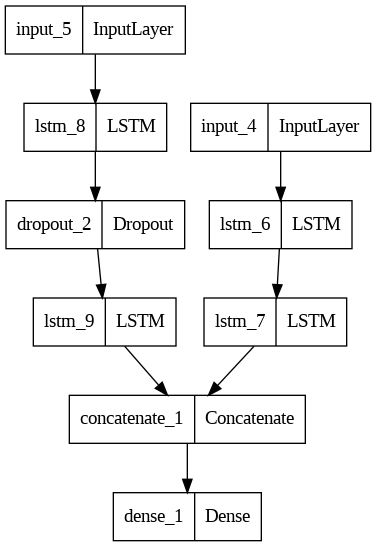

In [123]:
# Create the first LSTM model
input1 = keras.Input(shape=input_shape1)
lstm1 = keras.layers.LSTM(units=100, return_sequences=True)(input1)
# dropout1 = keras.layers.Dropout(0.2)(lstm1)
# lstm2 = keras.layers.LSTM(units=50, return_sequences=True)(dropout1)
# dropout2 = keras.layers.Dropout(0.2)(lstm2)
lstm3 = keras.layers.LSTM(units=25)(lstm1)
model1 = keras.Model(inputs=input1, outputs=lstm3)

# Create the second LSTM model
input2 = keras.Input(shape=input_shape2)
lstm4 = keras.layers.LSTM(units=150, return_sequences=True)(input2)
dropout3 = keras.layers.Dropout(0.2)(lstm4)
# lstm5 = keras.layers.LSTM(units=50, return_sequences=True)(dropout3)
# dropout4 = keras.layers.Dropout(0.2)(lstm5)
lstm6 = keras.layers.LSTM(units=75)(dropout3)
model2 = keras.Model(inputs=input2, outputs=lstm6)

# Get the last layer outputs of each model
output1 = model1.layers[-1].output
output2 = model2.layers[-1].output

# Concatenate the last layer outputs
concatenated_output = keras.layers.concatenate([output1, output2])

# Add a fully connected layer
# dense1 = keras.layers.Dense(units=150, activation='relu')(concatenated_output)
# dense2 = keras.layers.Dense(units=1, activation='sigmoid')(dense1)

dense2 = keras.layers.Dense(units=1, activation='sigmoid')(concatenated_output)

# Create the combined model
combined_model = keras.Model(inputs=[model1.input, model2.input], outputs=dense2)

combined_model.summary()
plot_model(combined_model)

In [124]:
# Compile the model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history= combined_model.fit([X_SA_train, X_train], y_train, epochs=40, batch_size=32, validation_split = 0.2 )

Epoch 1/40
47/47 [==============================] - 17s 109ms/step - loss: 0.6960 - accuracy: 0.5095 - val_loss: 0.6930 - val_accuracy: 0.5216
Epoch 2/40
47/47 [==============================] - 3s 61ms/step - loss: 0.6945 - accuracy: 0.5014 - val_loss: 0.7006 - val_accuracy: 0.4784
Epoch 3/40
47/47 [==============================] - 3s 62ms/step - loss: 0.6915 - accuracy: 0.5210 - val_loss: 0.6963 - val_accuracy: 0.4811
Epoch 4/40
47/47 [==============================] - 5s 99ms/step - loss: 0.6912 - accuracy: 0.5434 - val_loss: 0.6886 - val_accuracy: 0.5243
Epoch 5/40
47/47 [==============================] - 3s 70ms/step - loss: 0.6881 - accuracy: 0.5379 - val_loss: 0.6847 - val_accuracy: 0.5784
Epoch 6/40
47/47 [==============================] - 3s 59ms/step - loss: 0.6796 - accuracy: 0.5799 - val_loss: 0.6601 - val_accuracy: 0.7027
Epoch 7/40
47/47 [==============================] - 3s 62ms/step - loss: 0.6091 - accuracy: 0.6877 - val_loss: 0.5113 - val_accuracy: 0.8189
Epoch 8/40


In [125]:
# Evaluate the model
loss, accuracy = combined_model.evaluate([X_SA_test, X_test], y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

15/15 [==============================] - 0s 17ms/step - loss: 0.0958 - accuracy: 0.9567
Test Loss: 0.09579703211784363
Test Accuracy: 0.9567099809646606


In [126]:
predictions = combined_model.predict([X_SA_test,X_test])

15/15 [==============================] - 2s 16ms/step


In [127]:
threshold = 0.5  # Threshold to convert probabilities to binary labels

incorrect_predictions = []

# Convert predicted probabilities to binary labels
binary_predictions = np.where(predictions > threshold, 1, 0)

for true_label, predicted_label in zip(y_test, binary_predictions):
    if true_label != predicted_label:
        incorrect_predictions.append((true_label, predicted_label))

incorrect_predictions_count = len(incorrect_predictions)
print(f"Number of Incorrect Predictions: {incorrect_predictions_count}")

Number of Incorrect Predictions: 20


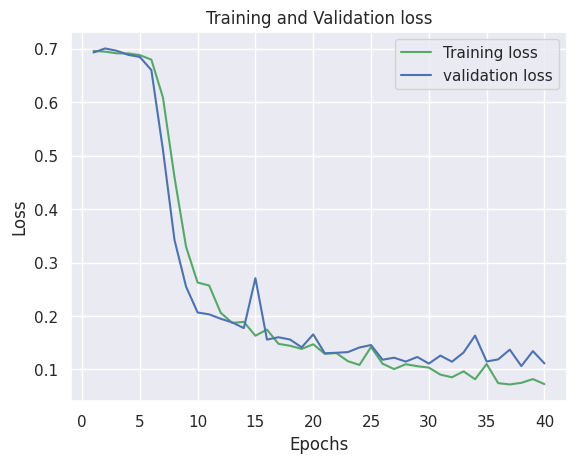

In [128]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

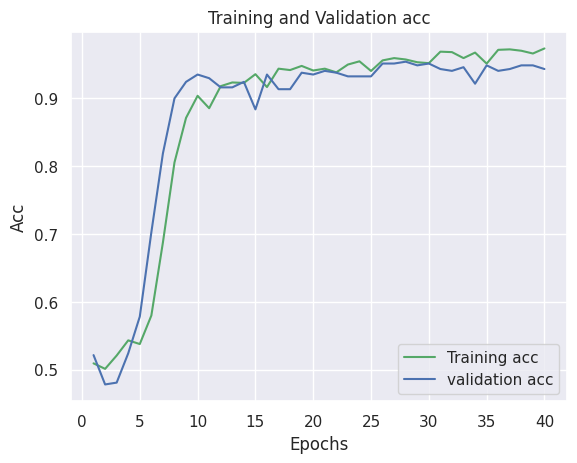

In [129]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [130]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert predicted probabilities to binary labels
binary_predictions = np.where(predictions > threshold, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions, digits=4))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, binary_predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9454    0.9698    0.9574       232
         1.0     0.9688    0.9435    0.9559       230

    accuracy                         0.9567       462
   macro avg     0.9571    0.9567    0.9567       462
weighted avg     0.9570    0.9567    0.9567       462

Confusion Matrix:
[[225   7]
 [ 13 217]]


In [131]:
# Prepare the input data for prediction (assuming X_test represents the most recent data available)
input_data_SA = scaled_features_SA[-lookback:]  # Select the most recent lookback period as input data
# Reshape the input data
input_data_SA = np.reshape(input_data_SA, (1, lookback, num_features_SA))  # Adjust the shape based on your specific lookback and feature dimensions

input_data = scaled_features[-lookback:]  # Select the most recent lookback period as input data
# Reshape the input data
input_data = np.reshape(input_data, (1, lookback, num_features))  # Adjust the shape based on your specific lookback and feature dimensions

# Make the prediction
prediction = combined_model.predict([input_data_SA, input_data])

# Interpret the prediction
if prediction > 0.5:
    price_movement = "Positive"
else:
    price_movement = "Negative"

# Print the predicted price movement
print("Next day's price movement:", price_movement)

1/1 [==============================] - 0s 28ms/step
Next day's price movement: Negative


# SINGLE LSTM

## TA-LSTM processing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)
print(data_set_scaled[0].size)

[[0.69600179 0.95242453 0.95761795 ... 0.65249573 0.47806662 0.        ]
 [0.72162407 0.95778012 0.96042279 ... 0.64874876 0.5235121  1.        ]
 [0.73075842 0.96215974 0.96308629 ... 0.66340681 0.50371678 1.        ]
 ...
 [0.63338424 0.04012201 0.03393228 ... 0.74196134 0.65365144 1.        ]
 [0.67417157 0.04296197 0.04193249 ... 0.7265157  0.60325611 1.        ]
 [0.61763267 0.04120636 0.04576824 ... 0.66161841 0.38492282 0.        ]]
20


In [ ]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 14
print(data_set_scaled.shape[0])
for j in range(18):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

In [ ]:
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

In [ ]:
X, Yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
Y=np.reshape(Yi,(len(Yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(Y)
print(Y.shape)

In [ ]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
Y_train, Y_test = Y[:splitlimit], Y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_train)

1845
(1845, 14, 18)
(462, 14, 18)
(1845, 1)
(462, 1)
[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


## SA-LSTM processing

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(new_df)
print(df_scaled)
print(df_scaled[0].size)

[[0.95575293 0.95554347 0.96010293 ... 0.95580024 0.57327263 0.        ]
 [0.96120628 0.95163066 0.95755404 ... 0.96125319 0.54571744 1.        ]
 [0.96334911 0.95137574 0.95933491 ... 0.96317718 0.62522367 1.        ]
 ...
 [0.09747834 0.09815244 0.09969114 ... 0.09745652 0.4577198  1.        ]
 [0.11183391 0.09690325 0.10802951 ... 0.11180888 0.38358321 1.        ]
 [0.09768685 0.11870528 0.09093904 ... 0.09766498 0.57756151 0.        ]]
7


In [ ]:
x = []
backcandles = 14
print(df_scaled.shape[0])
for j in range(6):#data_set_scaled[0].size):#last columns is target not X
    x.append([])
    for i in range(backcandles, df_scaled.shape[0]):#backcandles+2
        x[j].append(df_scaled[i-backcandles:i, j])

2321


In [ ]:
x=np.moveaxis(x, [0], [2])

In [ ]:
x, yi =np.array(x), np.array(df_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(x)
print(x.shape)
print(y)
print(y.shape)

[[[0.95575293 0.95554347 0.96010293 0.95580024 0.95580024 0.57327263]
  [0.96120628 0.95163066 0.95755404 0.96125319 0.96125319 0.54571744]
  [0.96334911 0.95137574 0.95933491 0.96317718 0.96317718 0.62522367]
  ...
  [0.97181727 0.95867527 0.96537358 0.97212747 0.97212747 0.67627416]
  [0.9573214  0.9509233  0.96144159 0.9571071  0.9571071  0.55072271]
  [0.96216794 0.94991302 0.93598753 0.96212745 0.96212745 0.53188953]]

 [[0.96120628 0.95163066 0.95755404 0.96125319 0.96125319 0.54571744]
  [0.96334911 0.95137574 0.95933491 0.96317718 0.96317718 0.62522367]
  [0.94304367 0.93122927 0.94020116 0.94326461 0.94326461 0.66682611]
  ...
  [0.9573214  0.9509233  0.96144159 0.9571071  0.9571071  0.55072271]
  [0.96216794 0.94991302 0.93598753 0.96212745 0.96212745 0.53188953]
  [0.93916045 0.92637626 0.92889675 0.93903629 0.93903629 0.56119161]]

 [[0.96334911 0.95137574 0.95933491 0.96317718 0.96317718 0.62522367]
  [0.94304367 0.93122927 0.94020116 0.94326461 0.94326461 0.66682611]
  [0

In [ ]:
# split data into train test sets
splitlimit = int(len(x)*0.8)
print(splitlimit)
x_train, x_test = x[:splitlimit], x[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1845
(1845, 14, 6)
(462, 14, 6)
(1845, 1)
(462, 1)
[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


## Building 2 LSTM models and join output with FCNN (consolidated)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input1 (InputLayer)      [(None, 14, 18)]     0           []                               
                                                                                                  
 model_input2 (InputLayer)      [(None, 14, 6)]      0           []                               
                                                                                                  
 model_LSTM_layer1 (LSTM)       (None, 150)          101400      ['model_input1[0][0]']           
                                                                                                  
 model_LSTM_layer2 (LSTM)       (None, 150)          94200       ['model_input2[0][0]']           
                                                                                            

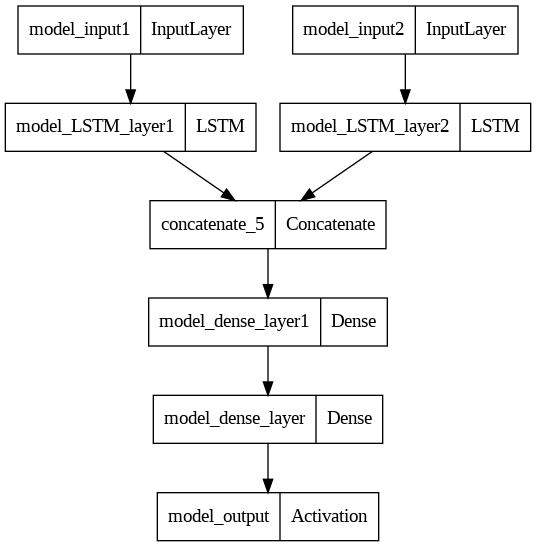

In [ ]:
np.random.seed(560)
#LSTM Model 1 for Technical Analysis 
input1 = Input(shape=(backcandles, 18), name='model_input1')
model_inputs1 = LSTM(150, name='model_LSTM_layer1')(input1)

#LSTM Model 2 for Sentiment Analysis
input2 = Input(shape=(backcandles, 6), name='model_input2')
model_inputs2 = LSTM(150, name='model_LSTM_layer2')(input2)

#Concatenating 2 LSTM outputs
model_inputs = concatenate([model_inputs1 ,model_inputs2], axis=1)

# model_inputs1 = Dense(64, name='model_flatten_layer1')(model_inputs1)
#model_inputs2 = Dense(64, name='model_flatten_layer2')(model_inputs2)

model_inputs = Dense(150, activation='relu', name='model_dense_layer1')(model_inputs)

model_inputs = Dense(1, name='model_dense_layer')(model_inputs)

model_output = Activation('sigmoid', name='model_output')(model_inputs)
model = Model(inputs=[input1,input2], outputs=model_output)
model.summary()
plot_model(model)

In [ ]:
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
history= model.fit(x=[X_train,x_train], y=[Y_train, y_train], batch_size=32, epochs=40, shuffle=True, validation_split = 0.15)

Epoch 1/40
49/49 [==============================] - 13s 109ms/step - loss: 0.2529 - val_loss: 0.2552
Epoch 2/40
49/49 [==============================] - 3s 55ms/step - loss: 0.2502 - val_loss: 0.2521
Epoch 3/40
49/49 [==============================] - 4s 77ms/step - loss: 0.2503 - val_loss: 0.2496
Epoch 4/40
49/49 [==============================] - 2s 43ms/step - loss: 0.2503 - val_loss: 0.2493
Epoch 5/40
49/49 [==============================] - 2s 43ms/step - loss: 0.2503 - val_loss: 0.2496
Epoch 6/40
49/49 [==============================] - 2s 43ms/step - loss: 0.2505 - val_loss: 0.2501
Epoch 7/40
49/49 [==============================] - 2s 42ms/step - loss: 0.2497 - val_loss: 0.2492
Epoch 8/40
49/49 [==============================] - 3s 60ms/step - loss: 0.2502 - val_loss: 0.2488
Epoch 9/40
49/49 [==============================] - 3s 71ms/step - loss: 0.2501 - val_loss: 0.2517
Epoch 10/40
49/49 [==============================] - 2s 42ms/step - loss: 0.2498 - val_loss: 0.2495
Epoch 1

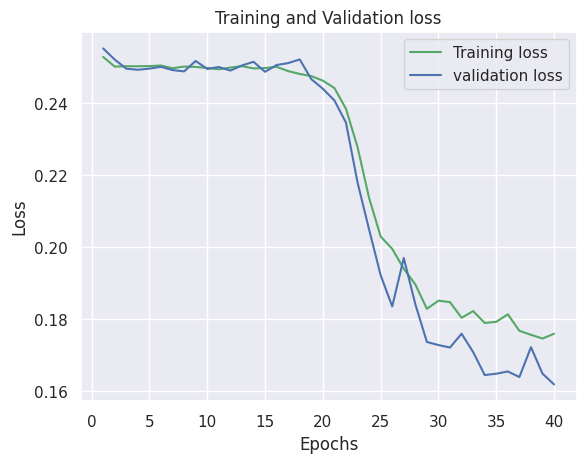

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict([X_test, x_test])
y_pred=np.where(y_pred > 0.50, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 1s 15ms/step
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]


In [ ]:
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

MNB_f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, y_pred)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

         0.0     0.7668    0.6980    0.7308       245
         1.0     0.6904    0.7604    0.7237       217

    accuracy                         0.7273       462
   macro avg     0.7286    0.7292    0.7272       462
weighted avg     0.7309    0.7273    0.7274       462

[[171  74]
 [ 52 165]]
Accuracy :  72.73  %
f1_score :  0.727
